# Artefact removal for pilot data

Pilot study uses language production task, i.e. we measure neural activities while the participant speaks phrases out. This means that the jaw of the participant will be moving during the task and it will create **muscle artefacts**. One way to overcome this problem is to use independent component analysis (ICA) to remove independent components associated with muscle artefacts. For this project we will perform artefact removal manually. Additionally, we will remove ocular (eye movement) and cardiac (heartbeat) artefact as well. These can be done with builtin method from MNE-python.

The information about ICA artefact removal can be found here: https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

In [1]:
from pathlib import Path
import numpy as np

import mne
from mne.preprocessing import ICA

In [2]:
%matplotlib qt

# Prepare the data

First we load the data. We assume that the original BTI data was reformatted as FIF format. This makes it easier to work with.

In [3]:
# Path to FIF file 
RAW_PATH = Path("/Users/hiro/Desktop/masters-project/data/pilot/raw.fif")

In [4]:
raw = mne.io.read_raw_fif(RAW_PATH, preload=True)
raw = raw.resample(100)  # Too much memory required for the original sampling rate
raw.info

Opening raw data file /Users/hiro/Desktop/masters-project/data/pilot/raw.fif...
    Range : 0 ... 1963774 =      0.000 ...   965.232 secs
Ready.
Opening raw data file /Users/hiro/Desktop/masters-project/data/pilot/raw-1.fif...
    Range : 1963775 ... 2146115 =    965.232 ...  1054.856 secs
Ready.
Reading 0 ... 2146115  =      0.000 ...  1054.856 secs...
482 events found
Event IDs: [  16  528 4096]
482 events found
Event IDs: [  16  528 4096]


<Info | 13 non-empty values
 bads: []
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 243 Magnetometers, 2 Stimulus, 23 Reference Magnetometers, 1 misc, 4 EEG
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: CTF MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 701 items (3 Cardinal, 698 Extra)
 file_id: 4 items (dict)
 highpass: 0.2 Hz
 lowpass: 50.0 Hz
 meas_date: 2022-04-08 11:40:53 UTC
 meas_id: 4 items (dict)
 nchan: 273
 projs: []
 sfreq: 100.0 Hz
>

We also need events for epoching. Plot them to check they are correct

In [6]:
events_dict = {"noun": 16, "verb": 528}

482 events found
Event IDs: [  16  528 4096]


/var/folders/y4/yvyyx89d4hlfft75vfn52pph0000gn/T/ipykernel_96049/2795137036.py:2: RuntimeWarning: event 4096 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id=events_dict)


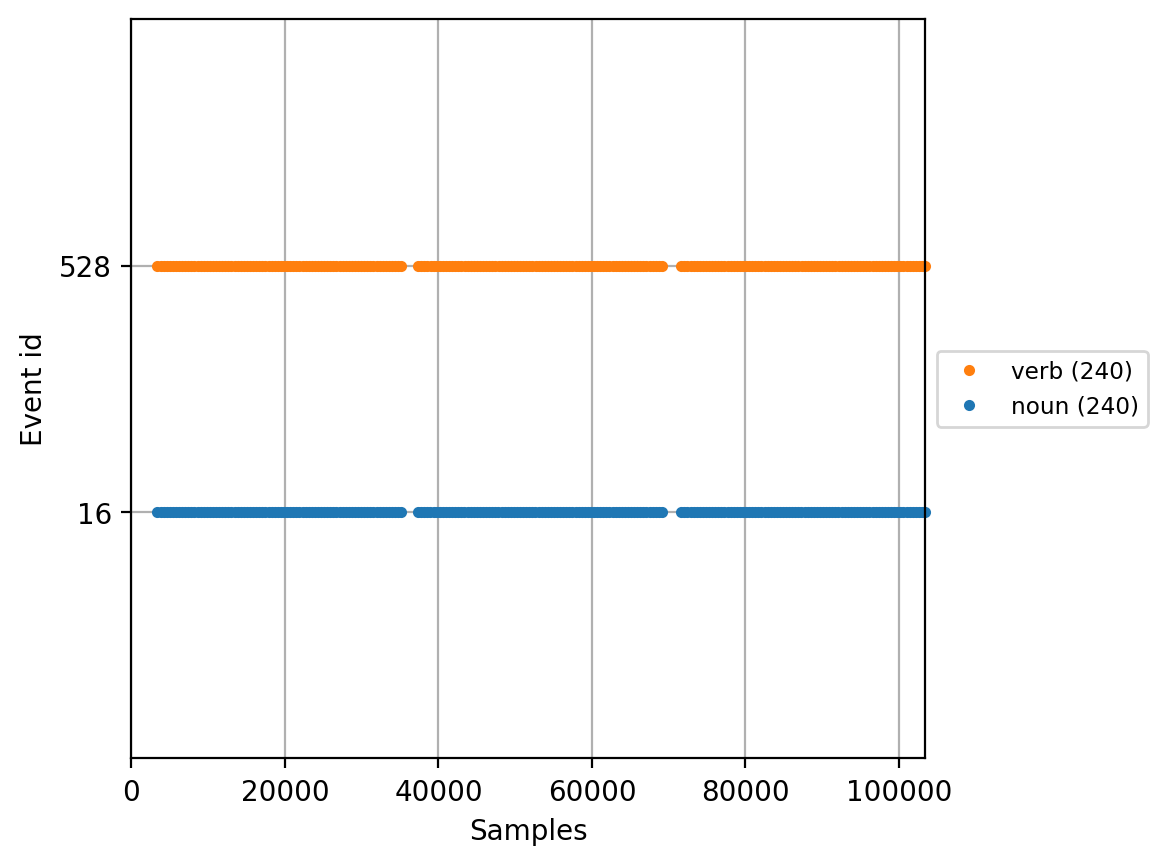

In [7]:
events = mne.find_events(raw)
mne.viz.plot_events(events, event_id=events_dict)

Let’s see the evoked field before repairing

In [8]:
tmin = -1.
tmax = 4.

Epoch the data from -1000 ms to 4000 ms. 

In [9]:
epochs = mne.Epochs(raw, events, event_id=events_dict, tmin=tmin, tmax=tmax, preload=True)

Not setting metadata
480 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 480 events and 501 original time points ...
0 bad epochs dropped


Plot the evoked field. As you can see, the signal contains huge deflections. The signal strength should not be in the order of tens of thousands of fT.

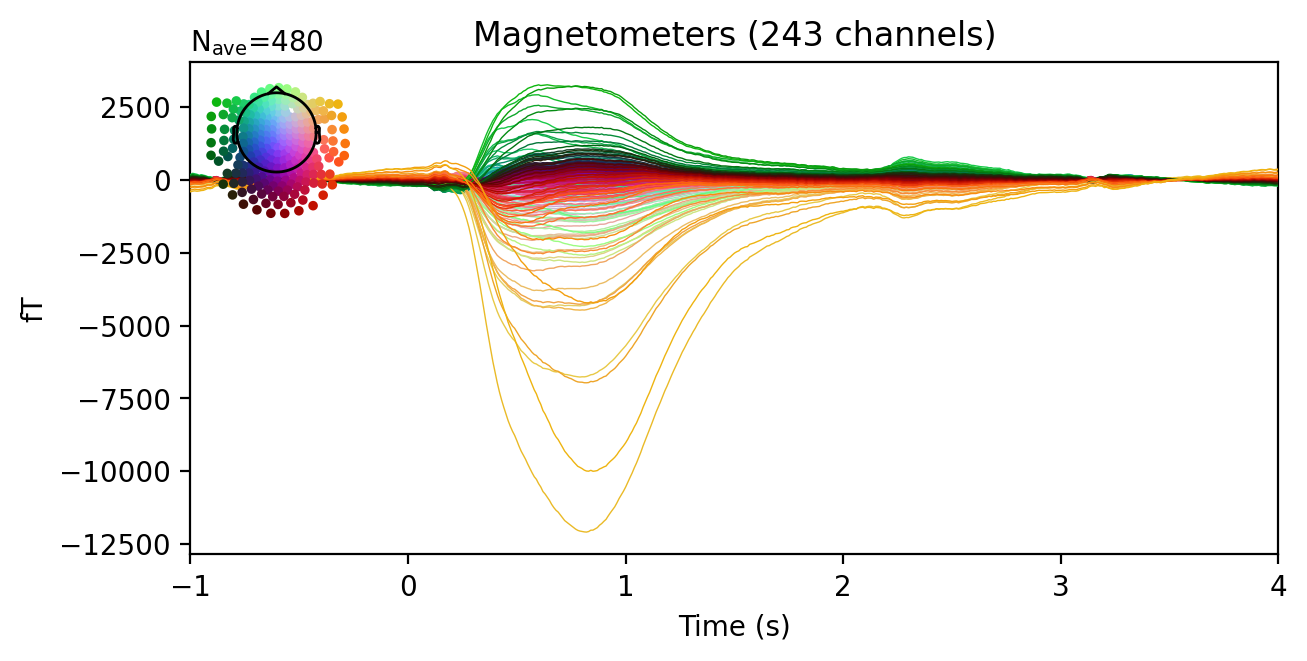

In [10]:
epochs.average().plot(picks="meg", spatial_colors=True)

# Perform ICA

To perform ICA, we must first remove slow drifts. For this we apply a high-pass filter.

In [11]:
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    0.8s finished


We can now fit the ICA model. (NB On the original data this could take a **very long time**.)

In [12]:
ica = ICA(n_components=.99, max_iter="auto", random_state=97)
ica.fit(filt_raw.pick(["meg", "eeg"]))
ica

Fitting ICA to data using 247 channels (please be patient, this may take a while)
Selecting by explained variance: 53 components
Fitting ICA took 14.4s.


<ICA | raw data decomposition, method: fastica (fit in 63 iterations on 105485 samples), 53 ICA components explaining 99.0 % of variance (247 PCA components available), channel types: mag, eeg, no sources marked for exclusion>

Automatically detect artefact components

In [13]:
ecg_indices, ecg_scores = ica.find_bads_ecg(filt_raw, ch_name="ECG", method='correlation', threshold='auto')
eog_indices, eog_scores = ica.find_bads_eog(filt_raw, ch_name=["VEOG", "HEOG"])
oo_indices, oo_scores = ica.find_bads_eog(filt_raw, ch_name=["OO"])

... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1000 s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Using EOG channels: VEOG, HEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Using EOG channel: OO
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
-

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [14]:
art = list(set(eog_indices + ecg_indices + oo_indices))
art.sort()
print(f"Ocular artefacts {eog_indices}")
print(f"Cardiac artefacts {ecg_indices}")
print(f"Muscular artefacts {oo_indices}")
print(f"All automatically detected artefacts {art}")

Ocular artefacts [43]
Cardiac artefacts [8, 27]
Muscular artefacts [27, 1, 43]
All automatically detected artefacts [1, 8, 27, 43]


In [15]:
ica.exclude = art

Let’s plot the components

Creating RawArray with float64 data, n_channels=53, n_times=105485
    Range : 0 ... 105484 =      0.000 ...  1054.840 secs
Ready.
Using matplotlib as 2D backend.


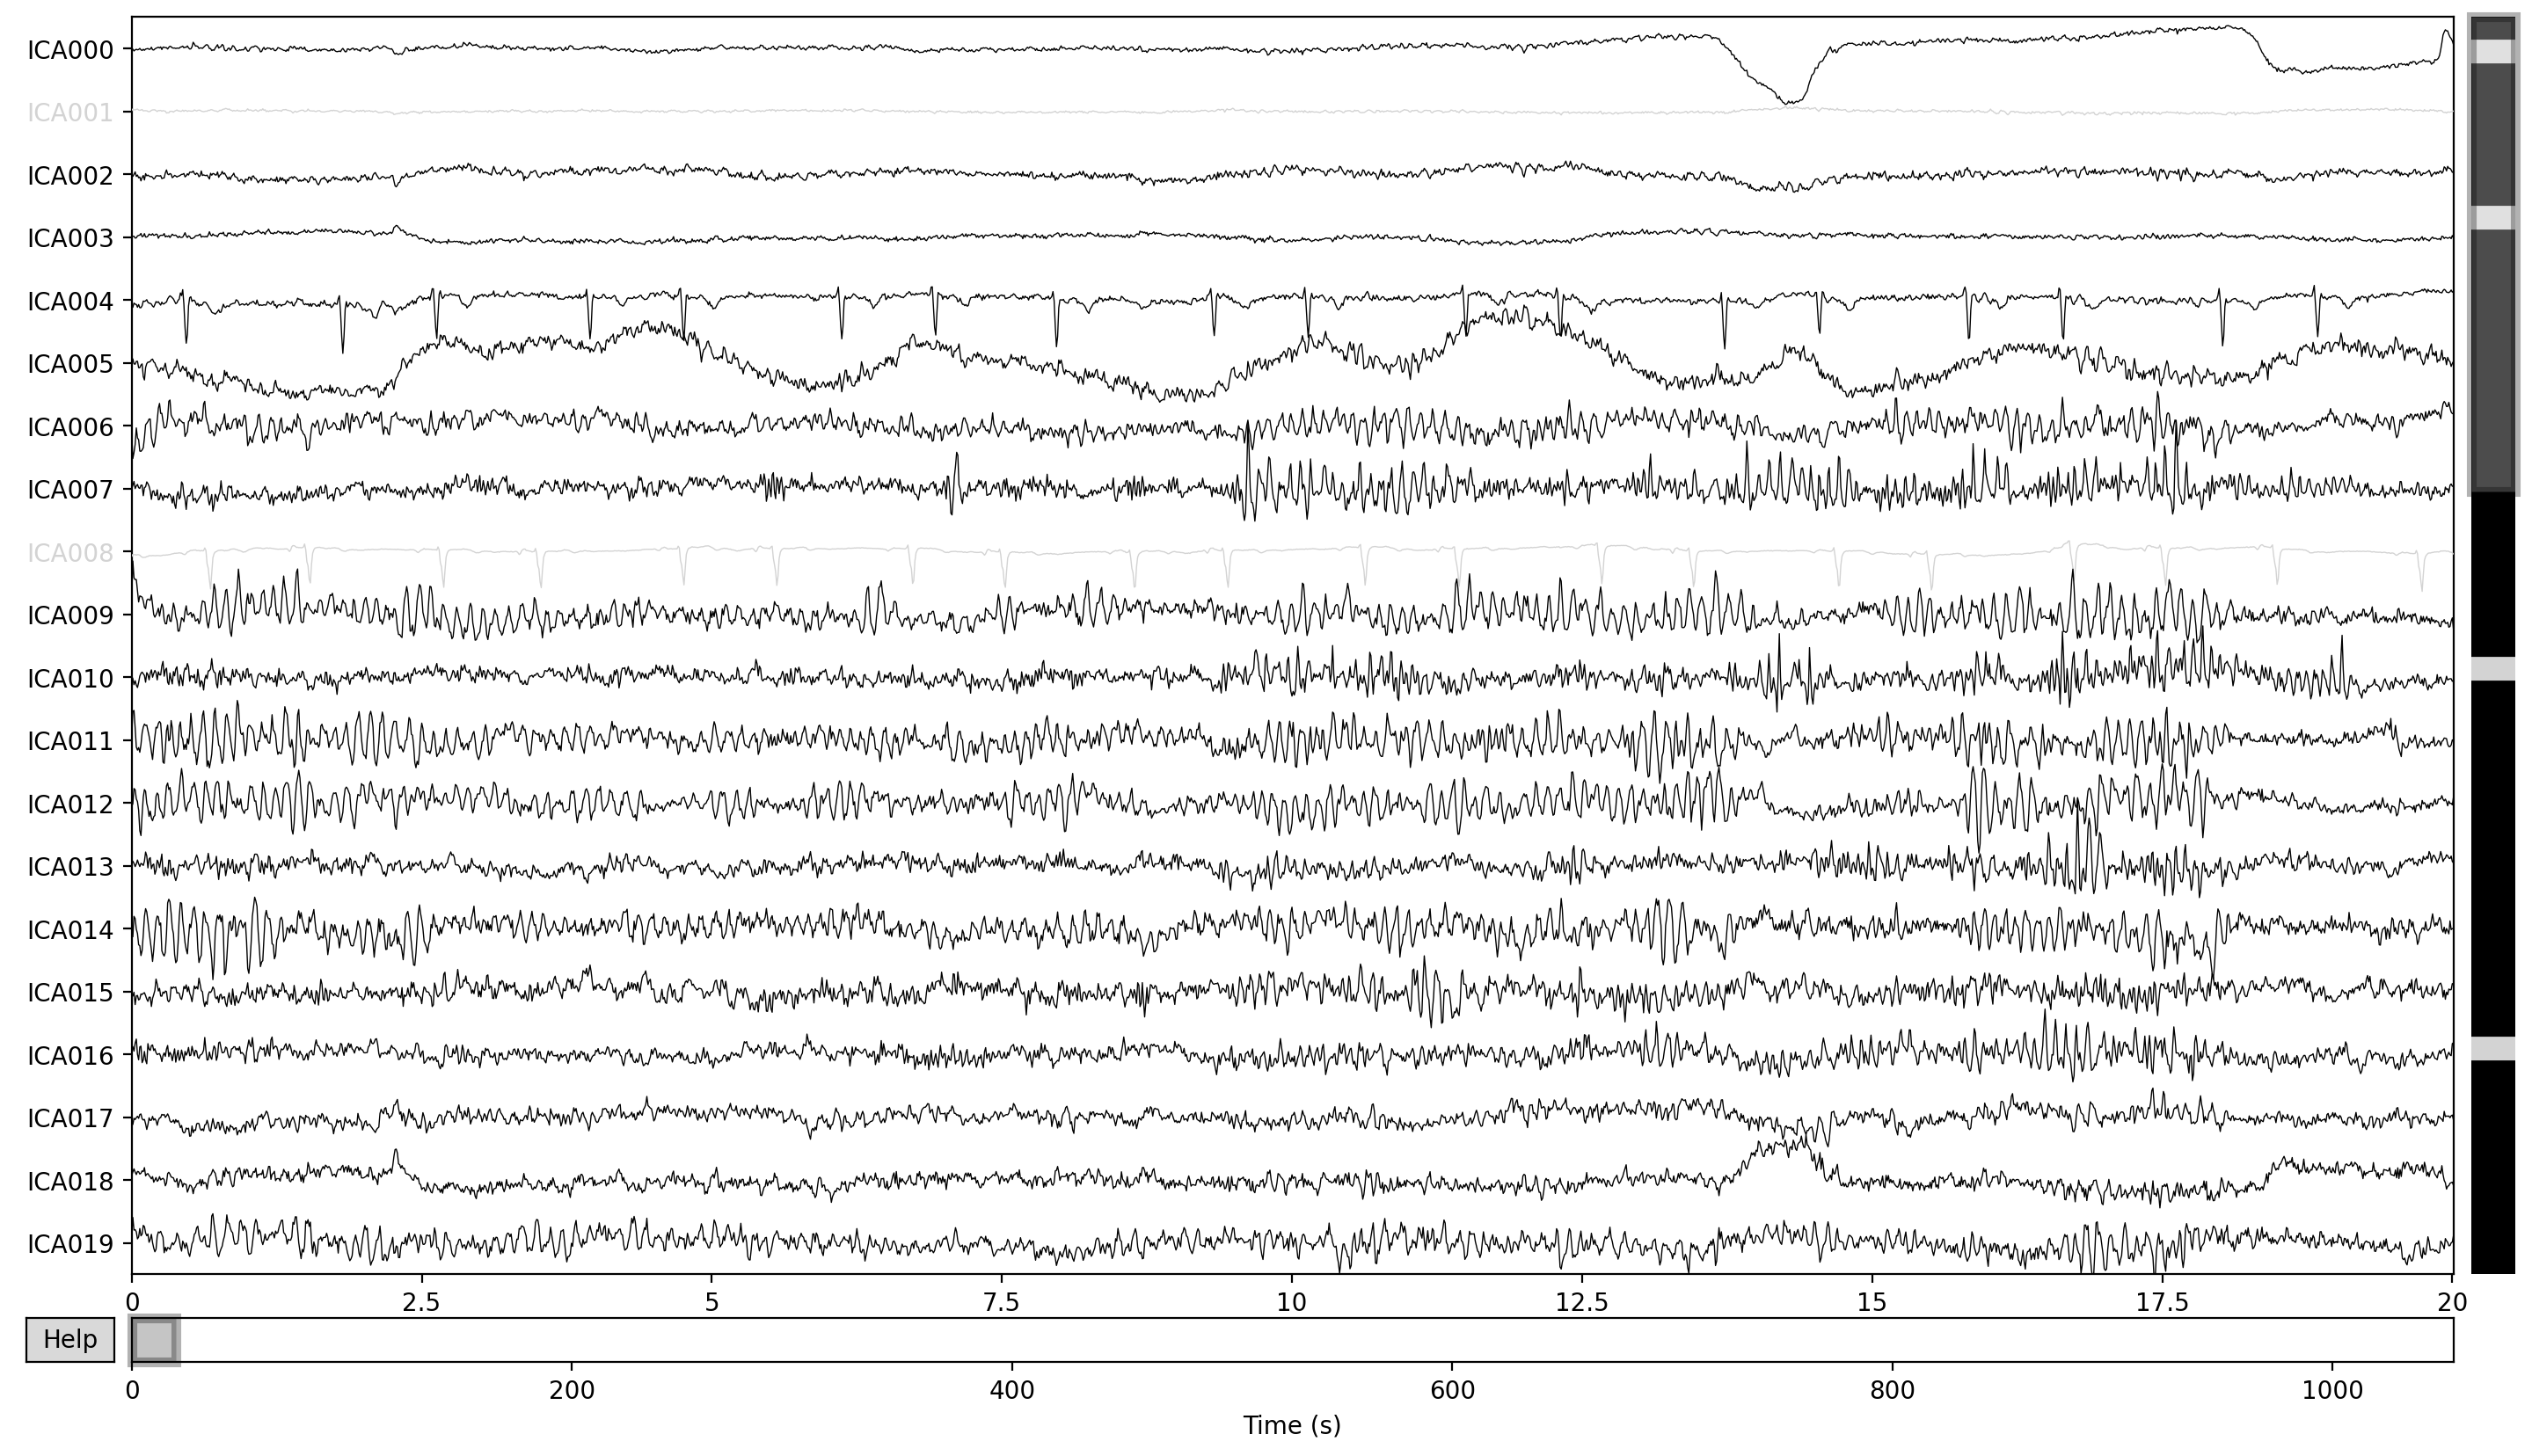

In [16]:
ica.plot_sources(raw)

Looks like the algorithm missed the component 4 which is clearly a cardiac artefact

In [17]:
art += [4]
ica.exclude = art

Here are first 10 components (rejected in grey)

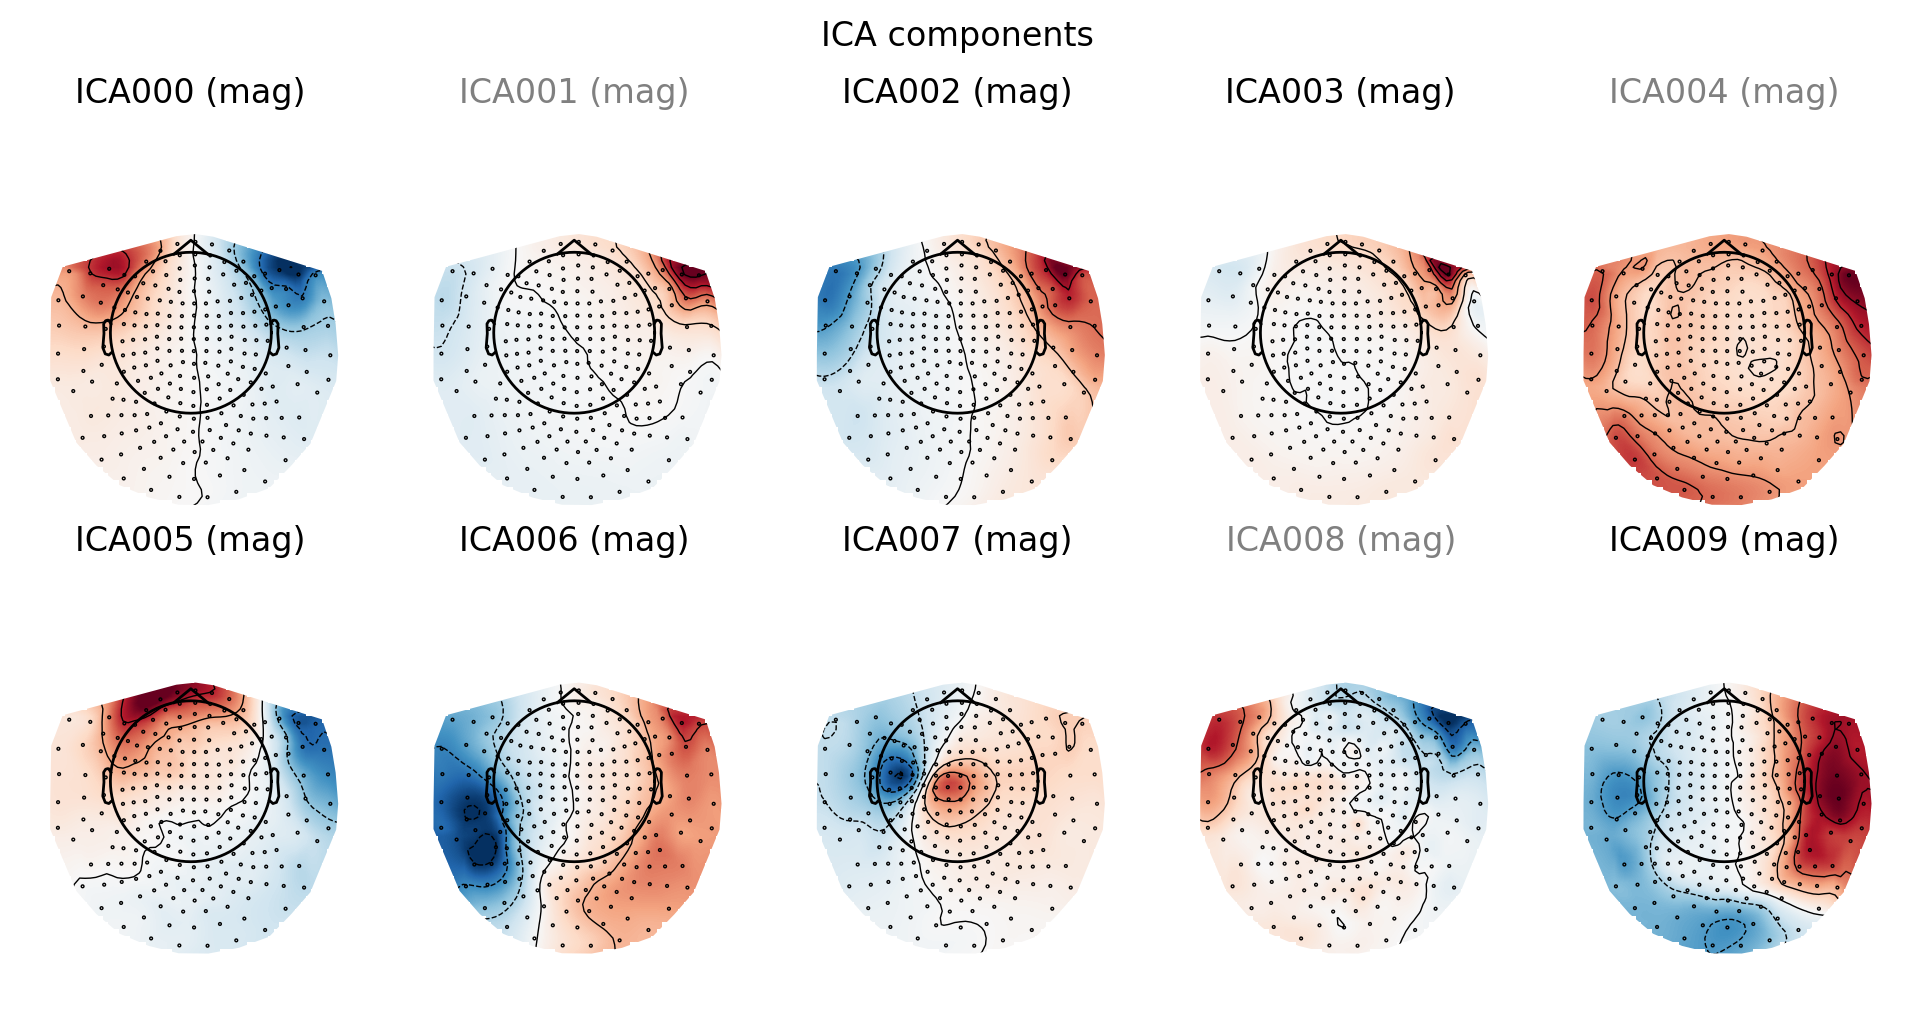

In [18]:
# First 10
ica.plot_components([i for i in range(10)])

After some trial and error I have decided that components 0, 2 and 3 are also muscle artefacts. (Possibly also 17 but the difference is negligible).

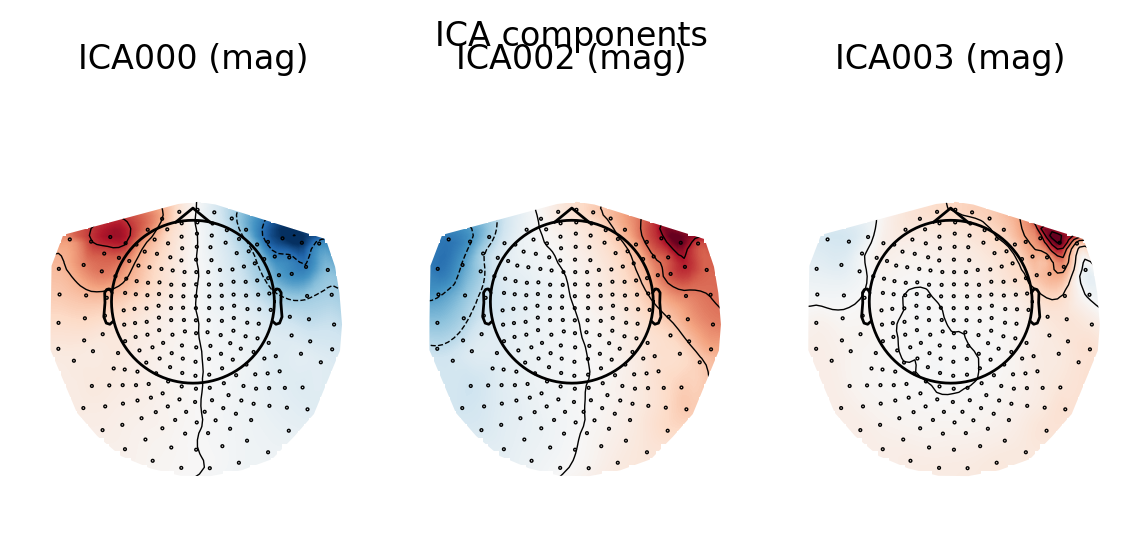

In [19]:
manual = [0, 2, 3]
ica.plot_components(manual)

Now we can reconstruct the original data without the artefacts

In [20]:
recon_raw = raw.copy()
ica.exclude = art + manual
ica.apply(recon_raw)

Applying ICA to Raw instance
    Transforming to ICA space (53 components)
    Zeroing out 8 ICA components
    Projecting back using 247 PCA components


<Raw | raw.fif, 273 x 105485 (1054.8 s), ~220.2 MB, data loaded>

Not setting metadata
482 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 482 events and 501 original time points ...
0 bad epochs dropped


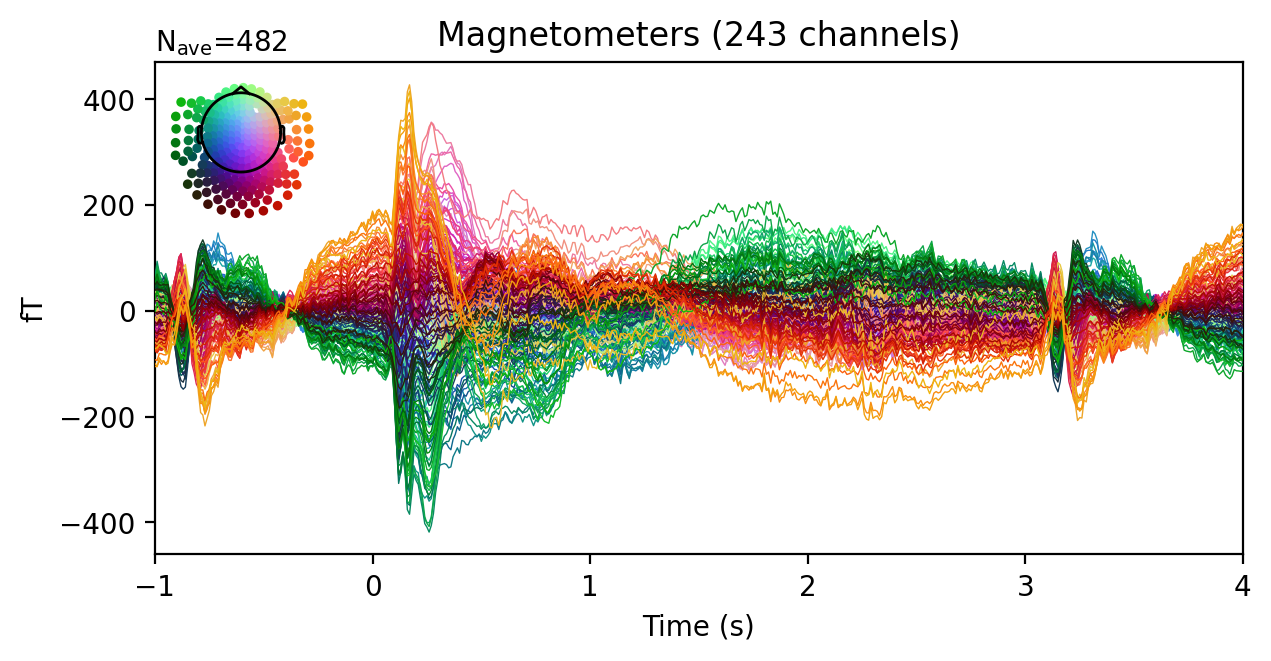

In [22]:
recon_epochs = mne.Epochs(recon_raw, events, tmin=tmin, tmax=tmax, preload=True)
recon_epochs.average().plot(picks="meg", spatial_colors=True)

The signal level falls below 400 fT which is reasonable.

# Apply the repair on the original and save

In [23]:
dst_dir = Path("/Users/hiro/Desktop/masters-project/data/derivatives/pilot")
fname = "repaired-raw.fif"

In [24]:
raw = mne.io.read_raw_fif(RAW_PATH, preload=True)
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
ica = ICA(n_components=.99, max_iter="auto", random_state=97)
ica.fit(filt_raw.pick(["meg", "eeg"]))
ica.exclude = art + manual
ica.apply(raw)
raw.save(dst_dir / fname)

Opening raw data file /Users/hiro/Desktop/masters-project/data/pilot/raw.fif...
    Range : 0 ... 1963774 =      0.000 ...   965.232 secs
Ready.
Opening raw data file /Users/hiro/Desktop/masters-project/data/pilot/raw-1.fif...
    Range : 1963775 ... 2146115 =    965.232 ...  1054.856 secs
Ready.
Reading 0 ... 2146115  =      0.000 ...  1054.856 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6715 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   30.5s finished


Fitting ICA to data using 247 channels (please be patient, this may take a while)
Selecting by explained variance: 56 components
Fitting ICA took 2488.6s.
Applying ICA to Raw instance
    Transforming to ICA space (56 components)
    Zeroing out 8 ICA components
    Projecting back using 247 PCA components
Writing /Users/hiro/Desktop/masters-project/data/derivatives/pilot/repaired-raw.fif
Overwriting existing file.
Writing /Users/hiro/Desktop/masters-project/data/derivatives/pilot/repaired-raw-1.fif
Closing /Users/hiro/Desktop/masters-project/data/derivatives/pilot/repaired-raw-1.fif
Closing /Users/hiro/Desktop/masters-project/data/derivatives/pilot/repaired-raw.fif
[done]
